# Выбор локации для скважины добывающей компании «ГлавРосГосНефть»

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Установим и подключим необходимые библиотеки:

In [1]:
!pip install -Uq scikit-learn
!pip install -q ydata-profiling
!pip install -q PyQt6

In [2]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error as mse, root_mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import os
from ydata_profiling import ProfileReport

Загрузим исходные данные:

In [3]:
def check_and_read(path, index_col=None):
    if os.path.exists(path):
        return pd.read_csv(path, index_col=index_col)
    else:
        print(f'Не найден файл по указанному пути: {path}')

        
df1 = check_and_read('datasets/geo_data_0.csv', index_col='id')
df2 = check_and_read('datasets/geo_data_1.csv', index_col='id')
df3 = check_and_read('datasets/geo_data_2.csv', index_col='id')
target = 'product'
df1.info()
df2.info()
df3.info()


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1  

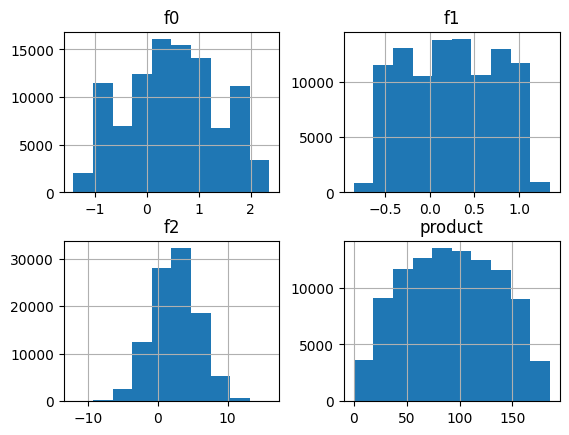

In [4]:
df1.hist()
plt.show()

In [5]:
ProfileReport(df1)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
ProfileReport(df2)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
ProfileReport(df3)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Видно, что во всех трёх наборах данных по 100000 строк с тремя континуальными признаками без пропусков и дубликатов, предобработка не требуется. Так как данных мало и они синтетические, анализ данных можно опустить.

## Обучение и проверка модели

Посмотрим, как распределён целевой признак запасов запасов нефти на скважине. Регионы 0 и 2 похожи друг на друга. В них распределение скорее симметричное, среднее и медиана близки (порядка 92-95), а разброс довольно велик (межквартильный размах от 55-60 до 130). Регион 1 отличается меньшими значениями (медина 57, среднее 69), но они скорее вытянуты вверх относительно медины, что и объясняет более высокое среднее.

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64


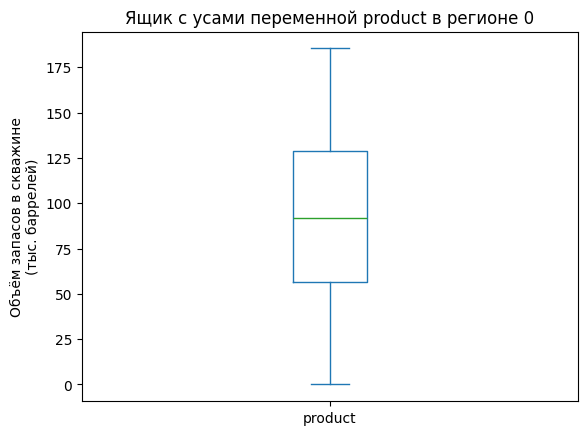

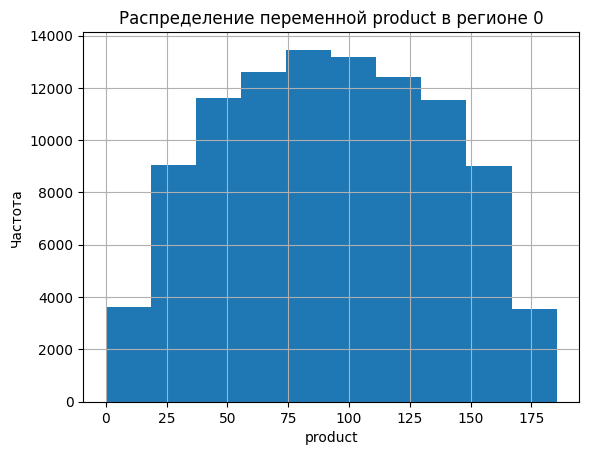

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64


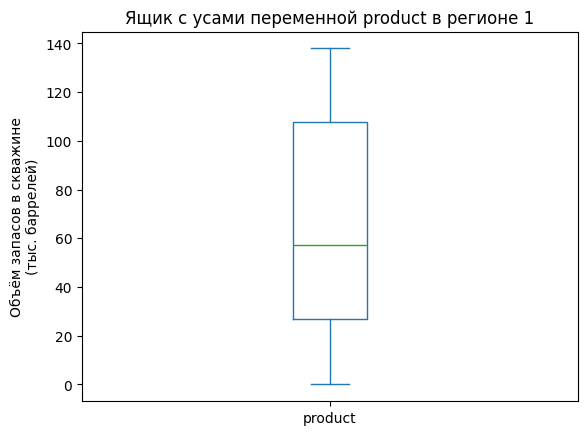

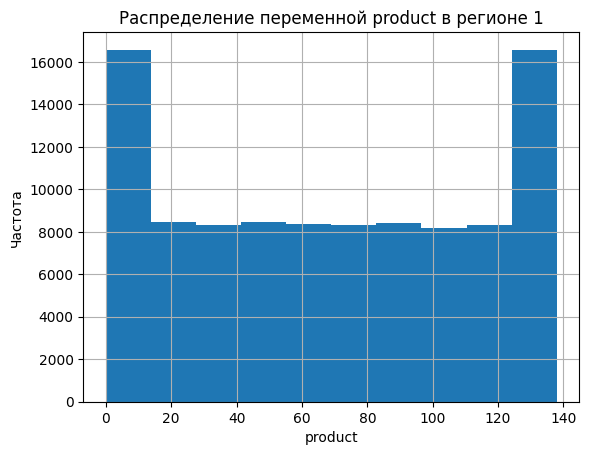

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64


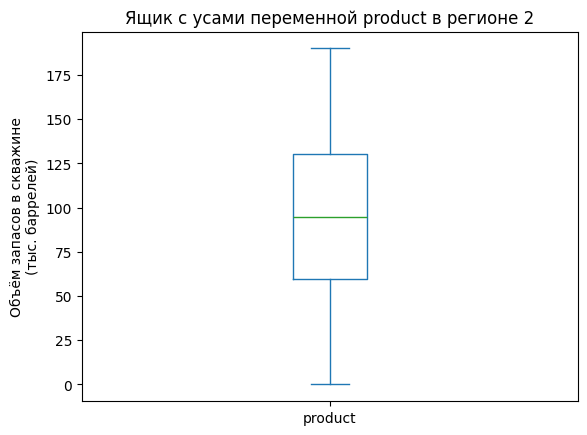

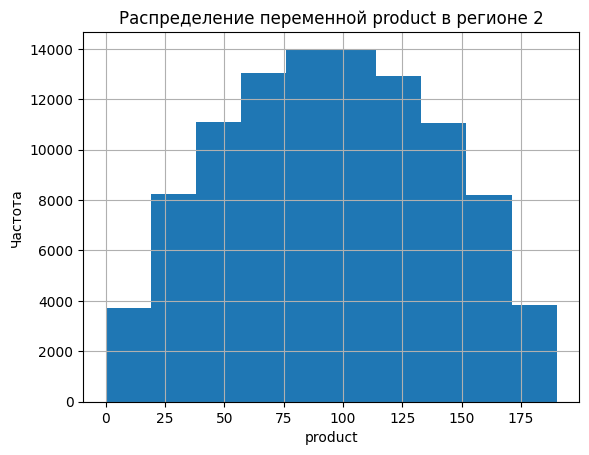

In [8]:
for i, df in enumerate((df1, df2, df3)):
    print(df[target].describe())
    df[target].plot.box()
    plt.title(f'Ящик с усами переменной {target} в регионе {i}')
    plt.ylabel('Объём запасов в скважине\n(тыс. баррелей)')
    plt.show()
    df[target].hist()
    plt.title(f'Распределение переменной {target} в регионе {i}')
    plt.xlabel(f'{target}')
    plt.ylabel('Частота')
    plt.show()


Посмотрим на матрицу корреляций. Небольшая корреляция (0,46-0,48) с целевым признаком заметна только у переменной *f2* в регионах 0 и 2. В регионе 1 эта корреляция достигает 1:

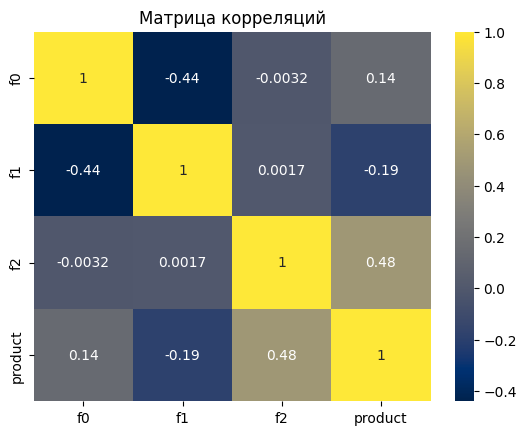

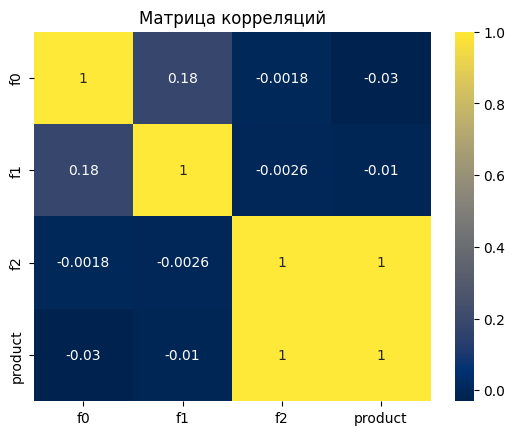

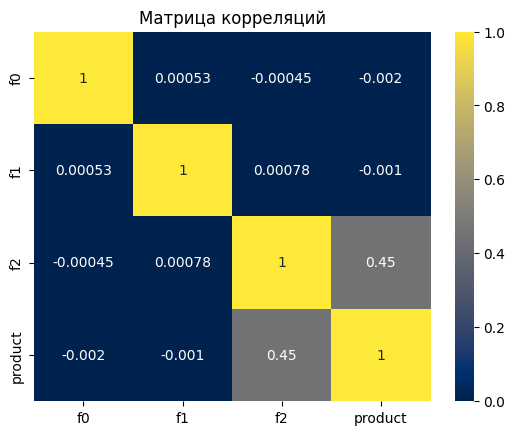

In [9]:
for i, df in enumerate((df1, df2, df3)):
    sns.heatmap(df.corr(), annot=True, cmap='cividis')
    plt.title('Матрица корреляций')
    plt.show()

В целях обеспечения предсказуемости, предполагается использование только линейной регрессии для обучения. Видно, что результаты наиболее точны в регионе 1 (ошибка менее 1 тыс. баррелей). В остальных регионах результаты ненадёжные.

In [10]:
random_state = 42
y_preds = []
y_trues = []

for i, df in enumerate((df1, df2, df3)):
    X, y = df.drop(target, axis=1), df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
    model = LinearRegression()
    model.fit(X_train, y_train)
    print(f'Регион {i}')
    y_preds.append(pd.Series(model.predict(X_test)))
    y_trues.append(y_test)
    print(f'Средний запас сырья согласно прогнозу: {y_preds[i].mean():.2f}')
    print(f'Метрика RMSE: {root_mean_squared_error(y_test, y_preds[i]):.2f}')


Регион 0
Средний запас сырья согласно прогнозу: 92.40
Метрика RMSE: 37.76
Регион 1
Средний запас сырья согласно прогнозу: 68.71
Метрика RMSE: 0.89
Регион 2
Средний запас сырья согласно прогнозу: 94.77
Метрика RMSE: 40.15


## Подготовка к расчёту прибыли

Посчитаем основные показатели в каждом регионе:

In [11]:
N_BEST = 200
EXPENSES = 10**10
BARREL_PRICE = 450_000

for i, y_true in enumerate(y_trues):
    barrels = pd.Series(y_true).sort_values(ascending=False)[:200].sum()
    barrels_mean = pd.Series(y_true).sort_values(ascending=False).mean()
    print('Регион', i)
    print('Необходимый для окупаемости объём разрабатывааемых запасов:', round(EXPENSES/BARREL_PRICE, 2))
    print('Суммарные запасы на 200 лучших точках:', round(barrels, 2)) 
    print('Суммарные запасы на 200 точках в среднем:', round(barrels_mean*200, 2)) 
    print('Средние запасы на точке:', round(barrels_mean, 2))
    print('Необходимые для окупаемости средние запасы на точке:', round(EXPENSES/BARREL_PRICE/N_BEST, 2))
    print()
    
    
def count_benefit(pred, true, BARREL_PRICE=BARREL_PRICE, EXPENSES=EXPENSES):
    best_indexes = pred.sort_values(ascending=False)[:200].index
    return true.iloc[best_indexes].sum()*BARREL_PRICE-EXPENSES


Регион 0
Необходимый для окупаемости объём разрабатывааемых запасов: 22222.22
Суммарные запасы на 200 лучших точках: 36687.38
Суммарные запасы на 200 точках в среднем: 18465.19
Средние запасы на точке: 92.33
Необходимые для окупаемости средние запасы на точке: 111.11

Регион 1
Необходимый для окупаемости объём разрабатывааемых запасов: 22222.22
Суммарные запасы на 200 лучших точках: 27589.08
Суммарные запасы на 200 точках в среднем: 13745.08
Средние запасы на точке: 68.73
Необходимые для окупаемости средние запасы на точке: 111.11

Регион 2
Необходимый для окупаемости объём разрабатывааемых запасов: 22222.22
Суммарные запасы на 200 лучших точках: 37660.28
Суммарные запасы на 200 точках в среднем: 19030.2
Средние запасы на точке: 95.15
Необходимые для окупаемости средние запасы на точке: 111.11



Заметно, что в среднем скважины недостаточно прибыльны, чтобы покрыть затраты. Но если брать именно лучшие, то во всех регионах можно достичь прибыли. При этом регион 1 уступает прочим как в среднем, так и на лучших точках.

## Расчёт прибыли и рисков 

Рассчитаем прибыль в каждом регионе через процедуру *Bootstrap* с 1000 итераций:

Регион 0
Средняя прибыль: 399575478
Квантиль 2,5%: -110467895
Квантиль 97,5%: 897460328
Вероятность получить убытки: 6.00%

Регион 1
Средняя прибыль: 452576594
Квантиль 2,5%: 52309410
Квантиль 97,5%: 830146313
Вероятность получить убытки: 0.90%

Регион 2
Средняя прибыль: 378705904
Квантиль 2,5%: -127779435
Квантиль 97,5%: 907923483
Вероятность получить убытки: 7.50%



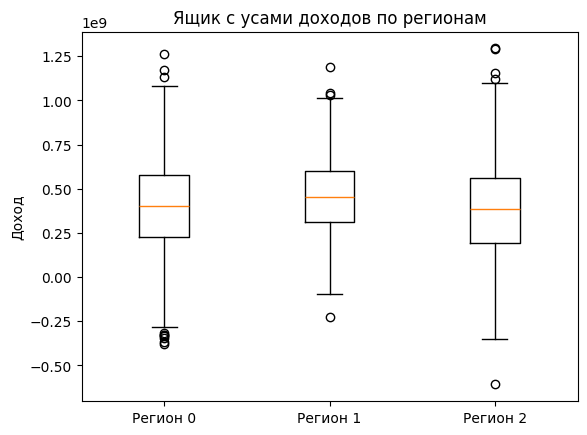

In [12]:
state = RandomState(42) 
n = 1000
k = 500
distrs = []
for i, y_pred in enumerate(y_preds):
    b = []
    for _ in range(n):
        b.append(count_benefit(y_pred.sample(k, replace=True, random_state=state), y_trues[i]))
    b = pd.Series(b)
    print('Регион', i)
    print('Средняя прибыль:', round(b.mean()))
    print('Квантиль 2,5%:', round(b.quantile(0.025)))
    print('Квантиль 97,5%:', round(b.quantile(0.975)))
    print('Вероятность получить убытки:', f'{(b<0).mean():.2%}')
    print()
    distrs.append(b)
    
plt.boxplot(distrs)
plt.title('Ящик с усами доходов по регионам')
plt.xticks([1, 2, 3], ['Регион 0', 'Регион 1', 'Регион 2'])
plt.ylabel('Доход')
plt.show()

Удивительно, но именно в регионе 1 достигаются наилучшие результаты. Средняя прибыль составляет 452 576 594, вероятность получить убытки равна 0.9%. Таким образом, именно регион 1 можно предложить для разработки, так как он единственный соответствует требованиям с точки зрения рисков (шанс получить убытки менее порога в 2,5%, тогда как в других регионах 6% и более) и имеет наивысшую среднюю прибыль.